# Methods

## 1. Loading, Wrangling, and Cleaning the Data

In [1]:
#loading in the library necessary
library(tidyverse)
install.packages("tidyverse")
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
library(GGally)
library(ISLR)

#formatting
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes     

Our data analysis was performed using a classification model, where a positive or negative diagnosis of heart disease in a patient was predicted based on the individual's various attributes. We selected predictors based on expected relevance to our thesis, which was to explore the correlation between the dataset’s given attributes and coronary artery disease (CAD).

The original dataset contains the following attributes: 

1. Age in years (__age__)
> The ages in the dataset roughly range from early 30s - late 70s. 

2. __sex__ - EXCLUDED

3. Type of chest pain (__cp__)
> Angina is a type of chronic chest pain that occurs when the heart is deficient in oxygen, and is a common symptom of cardiac disease. The original dataset distinguishes chest pain into 4 classes:
> * __*angina*__ = typical angina, where the patient experiences normal anginal symptoms
> * __*abnang*__ = atypical angina, where the patient experiences abnormal anginal symptoms
> * __*notang*__ = non-anginal pain, where the patient experiences chest pain that is unrelated to oxygen deficiency in the heart
> * __*asympt*__ = asymptomatic, where the patient experiences no chest pain at all

4. Resting blood pressure in mmHg (__trestbps__)
> *Note*: a normal resting blood pressure is below 120/80 mmHg (simplified to 120 mmHg to fit the original data)

5. Serum cholesterol in mg/dL (__chol__)
> Serum cholesterol is the total amount of cholesterol in the blood. Over time, cholesterol build up can lead to vascular blockage, which often occurs in the arteries and is a leading factor in CAD.
> 
> *Note*: An average "healthy" serum cholesterol level is conventionally taken to be below 200 mg/dL (5.5 mmol/L). However, serum cholesterol is made up of different types of cholesterol, some of which are actually indicative of individual health and help to eliminate cholesterol build up. The dataset only provides values for total cholesterol levels; thus, we only analyze the relationship between _total_ cholesterol and CAD.

6. Fasting blood sugar in mg/dL (__fbs__)
> According to the World Health Organization (WHO), normal fasting blood sugar is expected to be between 70 and 100 mg/dL. Having a fasting blood sugar level of 100 mg/dL or higher is an indicator of prediabetes - a condition where insulin is increasingly overproduced in the body and puts the patient at a high risk of developing type 2 diabetes, cardiac diseases and stroke; type 2 diabetes is confirmed at a fasting blood sugar level of at least 125 mg/dL. The researchers of this dataset have categorized patients as either:
> * subceeding (__*fal*__) 120 mg/dL
> * exceeding (__*true*__) 120 mg/dL.

7. __restecg__ - EXCLUDED

8. Maximum heart rate achieved in bpm (__thalach__)
> Values were taken at time of hospital admission.
>
> *Note*: According to the Centers for Disease Control and Prevention (CDC), the expected maximum heart rate of an adult individual is generally taken to be the individual's age in years subtracted from 220 (220 - age). For our model, we analyzed the observed maximum heart rates based on relative deviation from each individual’s theoretical maximum heart rate.

9. __exang__ - EXCLUDED

10. __oldpeak__ - EXCLUDED

11. __slope__ - EXCLUDED

12. Number of major vessels imaged by fluoroscopy (__ca__)
> Fluoroscopy is a radiation technique that is often used to scan for vascular blockage in the heart, a common factor in CAD. The number of major vessels imaged by fluoroscopy is given as a range of 0-3.
> 
> _Note:_ It is not mentioned the specific vessels that were inspected for, however, we expect that they include the coronary arteries, which are the most common sites of vascular blockage in heart disease.

14. __thal__ - EXCLUDED
<!-- > Thalassemia is a genetic disorder characterized by insufficient hemoglobin production in the body, which reduces red blood cell longevity and efficient delivery of oxygen to the tissues via the blood. 
> * __*norm*__ = normal
> * __*fixed*__ = fixed defect
> * __*rever*__ = reversable defect -->

14. Diagnosis of CAD (__num__)
> _Note_: The dataset does not elaborate much on our classifier column of interest, only mentioning the classification of “heart disease”. “Heart disease” is a broad term for conditions that affect any part of the cardiovascular system; however, it is also interchangeably used with coronary artery disease (CAD), a disorder affiliated with the coronary arteries that commonly develops later in life. As the dataset exhibits a relatively late age range (early 30s - late 70s) and investigates attributes that seem to be directly involved with the heart, we have assumed that the dataset defines "heart disease" as CAD.
> 
> CAD diagnoses are classified as:
> * __*buff*__ = negative (not heart disease)
> * __*sick*__ = positive (confirmed heart disease)

The classifier we chose was the attribute __num__, which classifies patients as testing negative (__buff__) or positive (__sick__) for heart disease. The variables we chose for our model predictors were age (__age__), type of chest pain (__cp__), resting blood pressure (__trestbps__; mmHg), serum cholesterol (__chol__; mg/dL), fasting blood sugar (__fbs__; mg/dL), observed maximum heart rate (__thalach__; bpm), and the number of major vessels that exhibited vascular blockage for each patient (__ca__; 0-3). The remaining attributes (__sex, restecg, exang, oldpeak, slope,__ and __thal__) were excluded from our model due to perceived irrelevance and/or insufficient information for interpretation, and thus are not elaborated on in our report. We also removed the last column in the original dataset as no background information was provided for it. 

In [2]:
#loading the data
cleveland <- read_csv("https://raw.githubusercontent.com/JennWan/Group_Project/main/new%20data/newcleveland_data.csv", col_names = F, show_col_types = F)

#renaming variables for readability 
colnames(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

#removing 15th column (NA)
cleveland <- cleveland |>
                    select(!15)

print("Table 1.1: Original Cleveland dataset (with headers)")
cleveland

[1] "Table 1.1: Original Cleveland dataset (with headers)"


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0.0,fix,buff
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3.0,norm,sick
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2.0,rev,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3.0,norm,sick
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1.0,norm,buff
54,fem,notang,160,201,fal,norm,163,fal,0.0,up,1.0,norm,buff


In [3]:
#selecting predictors of interest
cleveland_tidy <- cleveland |>
                select(age, cp, trestbps, chol, fbs, thalach, ca, num) |>
                mutate(cp = as_factor(cp),
                       trestbps = as.integer(trestbps), 
                       chol = as.integer(chol),  
                       fbs = as_factor(fbs),  
                       thalach = as.integer(thalach),
                       ca = as.integer(ca), 
                       ca = as_factor(ca),  
                       num = as_factor(num)) |>
                filter(!is.na(ca))

print("Table 1.2: Tidy dataset (excluded predictors)")
cleveland_tidy

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion”


[1] "Table 1.2: Tidy dataset (excluded predictors)"


age,cp,trestbps,chol,fbs,thalach,ca,num
<dbl>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<fct>
63,angina,145,233,true,150,0,buff
67,asympt,160,286,fal,108,3,sick
67,asympt,120,229,fal,129,2,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,notang,118,149,fal,126,3,sick
74,abnang,120,269,fal,121,1,buff
54,notang,160,201,fal,163,1,buff


<!-- explain NA coercion error (?) -->
> _Note:_ The original dataset contained missing values in the form of "?" in the __ca__ column. In order to remove them, we converted __ca__ to whole numbers using as.integer() to induce conversion of the missing values to NA so that they could be filtered out using the !is.na() function.

## 2. Preprocessing the Data

In [4]:
# find the statistics (mean/max/min) of numerical variables (unstandardized)

mean_table <- cleveland_tidy |>
    mutate(mean_age = mean(age), 
          mean_trestbps = mean(trestbps), 
          mean_chol = mean(chol), 
          mean_thalach = mean(thalach)) |>
    select(mean_age, mean_trestbps, mean_chol, mean_thalach) |>
    slice(1)
max_table <- cleveland_tidy |>
    mutate(max_age = max(age), 
          max_trestbps = max(trestbps),
          max_chol = max(chol), 
          max_thalach = max(thalach)) |>
    select(max_age, max_trestbps, max_chol, max_thalach) |>
    slice(1)

min_table <- cleveland_tidy |>
    mutate(min_age = min(age), 
          min_trestbps = min(trestbps),
          min_chol = min(chol), 
          min_thalach = min(thalach)) |>
    select(min_age, min_trestbps, min_chol, min_thalach) |>
    slice(1)

print("Table 2.1: Statistics of Unstandardized Numerical Variables (age; resting blood pressure; blood cholesterol; maximum heart rate)")
print("2.1.1: Mean Stats")
mean_table
print("2.1.2: Max Stats")
max_table
print("2.1.3: Min Stats")
min_table

[1] "Table 2.1: Statistics of Unstandardized Numerical Variables (age; resting blood pressure; blood cholesterol; maximum heart rate)"
[1] "2.1.1: Mean Stats"


mean_age,mean_trestbps,mean_chol,mean_thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.51007,131.5805,246.906,149.4664


[1] "2.1.2: Max Stats"


max_age,max_trestbps,max_chol,max_thalach
<dbl>,<int>,<int>,<int>
77,200,564,202


[1] "2.1.3: Min Stats"


min_age,min_trestbps,min_chol,min_thalach
<dbl>,<int>,<int>,<int>
29,94,126,71


In [5]:
# standardization of numerical variables except age (trestbps, chol, thalach)
# according to normal/healthy parameters (outlined above)

cleveland_thalach <- cleveland_tidy |>
                mutate(norm_thalach = (220 - age))

cleveland_tidier <- cleveland_thalach |>
                mutate(sd_thalach = (norm_thalach - thalach)/thalach,
                      sd_trestbps = (trestbps - 120)/120,
                      sd_chol = (chol - 200)/200) |>
                select(age, cp, sd_trestbps, sd_chol, fbs, sd_thalach, ca, num)
print("Table 2.2: Standardization of resting blood pressure, serum cholesterol, and maximum heart rate")
cleveland_tidier

[1] "Table 2.2: Standardization of resting blood pressure, serum cholesterol, and maximum heart rate"


age,cp,sd_trestbps,sd_chol,fbs,sd_thalach,ca,num
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,angina,0.2083333,0.165,true,0.04666667,0,buff
67,asympt,0.3333333,0.430,fal,0.41666667,3,sick
67,asympt,0.0000000,0.145,fal,0.18604651,2,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,notang,-0.01666667,-0.255,fal,0.35714286,3,sick
74,abnang,0.00000000,0.345,fal,0.20661157,1,buff
54,notang,0.33333333,0.005,fal,0.01840491,1,buff


In [6]:
# find the statistics (mean/max/min) of standardized numerical variables

mean_table <- cleveland_tidier |>
    mutate(mean_age = mean(age), 
          mean_sd_trestbps = mean(sd_trestbps), 
          mean_sd_chol = mean(sd_chol), 
          mean_sd_thalach = mean(sd_thalach)) |>
    select(mean_age, mean_sd_trestbps, mean_sd_chol, mean_sd_thalach) |>
    slice(1)
max_table <- cleveland_tidier |>
    mutate(max_age = max(age), 
          max_sd_trestbps = max(sd_trestbps),
          max_sd_chol = max(sd_chol), 
          max_sd_thalach = max(sd_thalach)) |>
    select(max_age, max_sd_trestbps, max_sd_chol, max_sd_thalach) |>
    slice(1)

min_table <- cleveland_tidier |>
    mutate(min_age = min(age), 
          min_sd_trestbps = min(sd_trestbps),
          min_sd_chol = min(sd_chol), 
          min_sd_thalach = min(sd_thalach)) |>
    select(min_age, min_sd_trestbps, min_sd_chol, min_sd_thalach) |>
    slice(1)

print("Table 2.3: Statistics of Standardized Numerical Variables (age; resting blood pressure; blood cholesterol; maximum heart rate)")
print("2.3.1: Mean Stats (SD)")
mean_table
print("2.3.2: Max Stats (SD)")
max_table
print("2.3.3: Min Stats (SD)")
min_table

[1] "Table 2.3: Statistics of Standardized Numerical Variables (age; resting blood pressure; blood cholesterol; maximum heart rate)"
[1] "2.3.1: Mean Stats (SD)"


mean_age,mean_sd_trestbps,mean_sd_chol,mean_sd_thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.51007,0.09650447,0.2345302,0.1339804


[1] "2.3.2: Max Stats (SD)"


max_age,max_sd_trestbps,max_sd_chol,max_sd_thalach
<dbl>,<dbl>,<dbl>,<dbl>
77,0.6666667,1.82,1.15493


[1] "2.3.3: Min Stats (SD)"


min_age,min_sd_trestbps,min_sd_chol,min_sd_thalach
<dbl>,<dbl>,<dbl>,<dbl>
29,-0.2166667,-0.37,-0.1487179


In [7]:
# find the number and percentage of differing presence of heart disease observations 
# in our data set to check for class imbalance

print("Table 2.4: Counts of CAD-negative vs. CAD-positive diagnoses (buff vs. sick)")
num_obs <- nrow(cleveland_tidier)
    cleveland_tidier |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100)


[1] "Table 2.4: Counts of CAD-negative vs. CAD-positive diagnoses (buff vs. sick)"


num,count,percentage
<fct>,<int>,<dbl>
buff,161,54.02685
sick,137,45.97315


In [8]:
set.seed(2000)

# center, scaling and balancing the heart disease data
cleve_recipe <- recipe(num ~ ., data = cleveland_tidier) |>
    # step_scale(sd_trestbps, sd_chol, sd_thalach) |>
    # step_center(sd_trestbps, sd_chol, sd_thalach) |>
    step_upsample(num, over_ratio = 1, skip = FALSE) |>
    prep()

preprocessed_cleve <- bake(cleve_recipe, cleveland_tidier)

print("Table 2.5: Preprocessed Dataset")
preprocessed_cleve

[1] "Table 2.5: Preprocessed Dataset"


age,cp,sd_trestbps,sd_chol,fbs,sd_thalach,ca,num
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,angina,0.20833333,0.165,true,0.04666667,0,buff
37,notang,0.08333333,0.250,fal,-0.02139037,0,buff
41,abnang,0.08333333,0.020,fal,0.04069767,0,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,asympt,0.36666667,-0.120,true,0.7888889,2,sick
66,asympt,-0.06666667,0.060,fal,0.1666667,1,sick
62,asympt,0.00000000,0.335,fal,0.5959596,2,sick


In [9]:
# find the number and percentage of differing presence of heart disease observations in our data set
# double check class imbalance

print("Table 2.6: Counts of preprocessed CAD-negative vs. CAD-positive diagnoses (buff vs. sick)")
num_obs <- nrow(preprocessed_cleve)
    preprocessed_cleve |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100)

[1] "Table 2.6: Counts of preprocessed CAD-negative vs. CAD-positive diagnoses (buff vs. sick)"


num,count,percentage
<fct>,<int>,<dbl>
buff,161,50
sick,161,50


In [10]:
# create the TRAIN SET and TEST SET
set.seed(2000)

cleveland_split <- initial_split(preprocessed_cleve, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split) 
cleveland_test <- testing(cleveland_split)

## 3. Exploring Predictors of Interest

In [11]:
# comparing the average age for CAD-negative vs. CAD-positive patients (buff vs. sick)
exploration_tbl1 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_age = mean(age)) |>
    arrange(avg_age)

print("Table 3.1: Average ages for CAD-negative vs. CAD-positive patients (buff vs. sick)")
exploration_tbl1

[1] "Table 3.1: Average ages for CAD-negative vs. CAD-positive patients (buff vs. sick)"


num,avg_age
<fct>,<dbl>
buff,52.67500
sick,56.10833


In [12]:
# comparing average standard deviation of resting blood pressure, cholesterol, and 
# maximum heart rate for CAD-negative vs. CAD-positive patients (buff vs. sick)

# exploring standardized resting blood pressure (sd_trestbps)
exploration_tbl2 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_sd_trestbps = mean(sd_trestbps)) |>
    arrange(avg_sd_trestbps)

print("Table 3.2: Average standard deviation of resting blood pressure, serum cholesterol, and maximum heart rate for CAD-negative vs. CAD-positive patients (buff vs. sick)")

print("3.2.1: Average standard deviation of resting blood pressure")
exploration_tbl2

# exploring standardized cholesterol (sd_chol)
exploration_tbl3 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_sd_chol = mean(sd_chol)) |>
    arrange(avg_sd_chol)

print("3.2.2: Average standard deviation of serum cholesterol")
exploration_tbl3

# exploring standardized observed maximum heart rate (sd_thalach)
exploration_tbl4 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_sd_max_heartrate = mean(sd_thalach)) |>
    arrange(avg_sd_max_heartrate)

print("3.2.3: Average standard deviation of maximum heart rate")
exploration_tbl4


[1] "Table 3.2: Average standard deviation of resting blood pressure, serum cholesterol, and maximum heart rate for CAD-negative vs. CAD-positive patients (buff vs. sick)"
[1] "3.2.1: Average standard deviation of resting blood pressure"


num,avg_sd_trestbps
<fct>,<dbl>
buff,0.07770833
sick,0.12305556


[1] "3.2.2: Average standard deviation of serum cholesterol"


num,avg_sd_chol
<fct>,<dbl>
sick,0.226375
buff,0.236750


[1] "3.2.3: Average standard deviation of maximum heart rate"


num,avg_sd_max_heartrate
<fct>,<dbl>
buff,0.06016669
sick,0.23076989


In [13]:
# comparing the counts for types of chest pain, fasting blood sugar (>/< 120 mg/dL) and 
# number of major vessels with blockage found for CAD-negative vs. CAD-positive 
# patients (buff vs. sick)

# exploring chest pain (cp) statistics
exploration_tbl5 <- cleveland_train |>
    group_by(num, cp) |>
    summarize(count_cp = n()) |>
    arrange(desc(count_cp)) |>
    head(2)
    
print("Table 3.3: Counts for types of chest pain, fasting blood sugar (>/< 120 mg/dL) and number of major vessels with blockage found for CAD-negative vs. CAD-positive patients (buff vs. sick)")

print("3.3.1: Counts for types of chest pain (cp)")
exploration_tbl5

# exploring fasting blood sugar (fbs) statistics 
exploration_tbl6 <- cleveland_train |>
    group_by(num, fbs) |>
    summarize(count_fbs = n()) |>
    arrange(desc(count_fbs)) |>
    head(2)

print("3.3.2: Counts for types of fasting blood sugar (fbs; fal < 120 mg/dL)")
exploration_tbl6

# exploring major vascular blockage (ca) statistics
exploration_tbl7 <- cleveland_train |>
    group_by(num, ca) |>
    summarize(count_ca = n()) |>
    arrange(desc(count_ca)) |>
    head(2)

print("3.3.2: Counts of number of major vessels with blockage (ca; 0-3)")
exploration_tbl7

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "Table 3.3: Counts for types of chest pain, fasting blood sugar (>/< 120 mg/dL) and number of major vessels with blockage found for CAD-negative vs. CAD-positive patients (buff vs. sick)"
[1] "3.3.1: Counts for types of chest pain (cp)"


num,cp,count_cp
<fct>,<fct>,<int>
sick,asympt,92
buff,notang,46


`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "3.3.2: Counts for types of fasting blood sugar (fbs; fal < 120 mg/dL)"


num,fbs,count_fbs
<fct>,<fct>,<int>
buff,fal,103
sick,fal,102


`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "3.3.2: Counts of number of major vessels with blockage (ca; 0-3)"


num,ca,count_ca
<fct>,<fct>,<int>
buff,0,95
sick,1,49


[1] "Figure 1: Scatter plot visualization of numerical predictor relationships with CAD/other predictors"


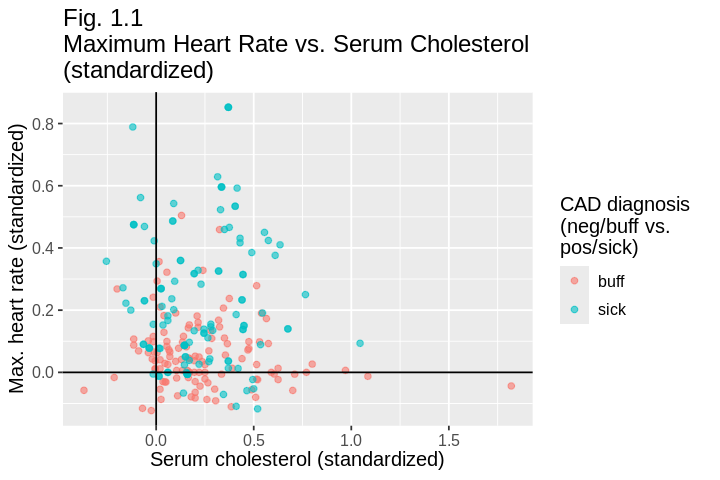

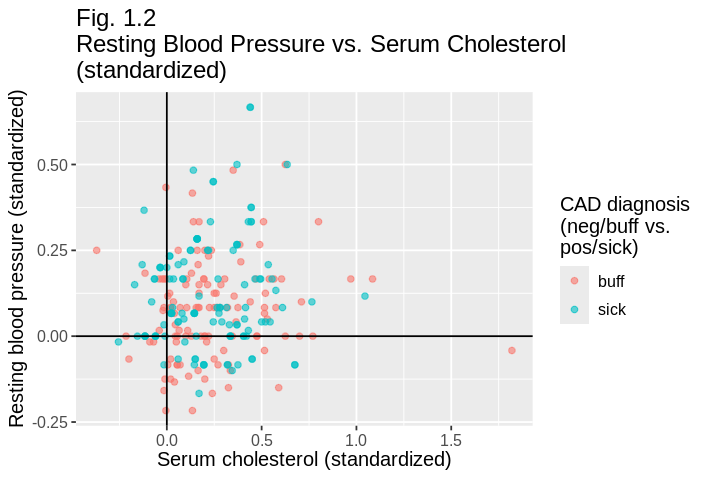

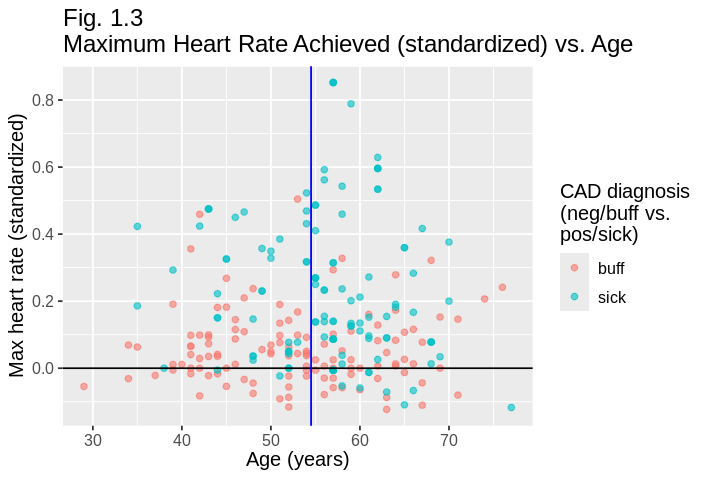

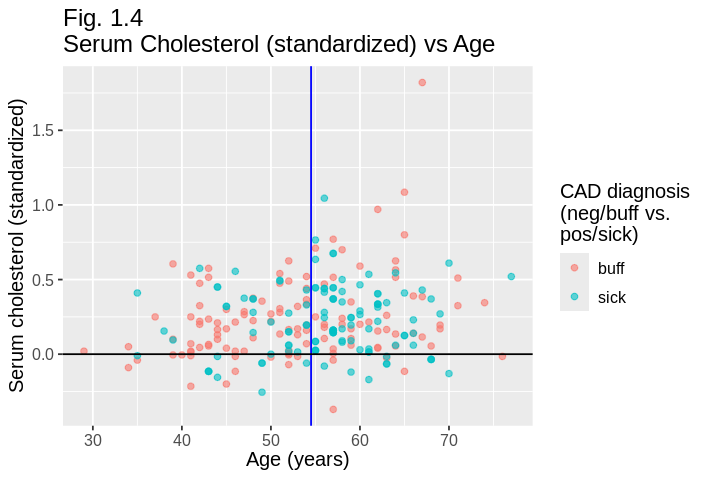

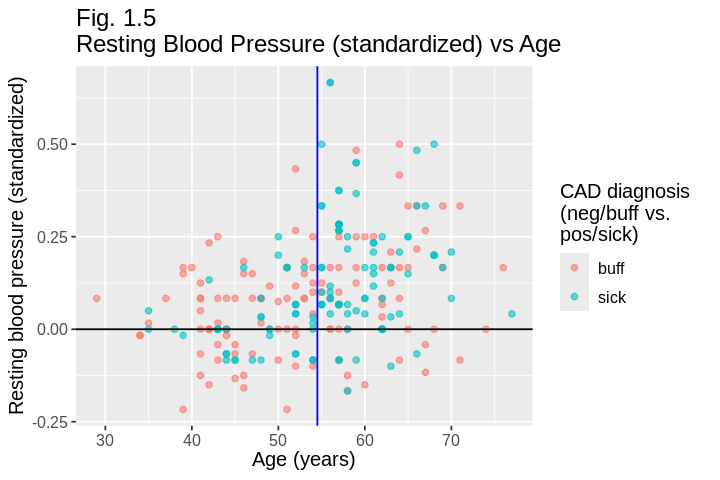

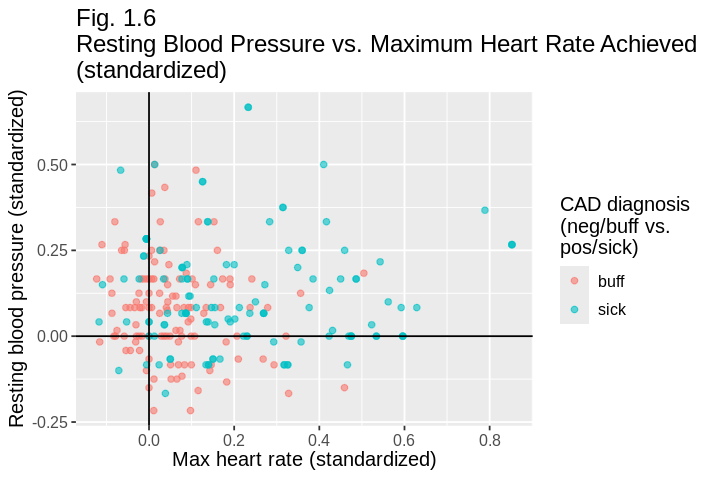

In [37]:
# scatter plot visualizations of the relationships of numerical predictors of interest with CAD/each other

options(repr.plot.height = 4, repr.plot.width = 6)

# draw a scatter plot to visualize the relationship between serum cholesterol (standardized)
# and observed maximum heart rate (standardized)

print("Figure 1: Scatter plot visualization of numerical predictor relationships with CAD/other predictors")

exploration_plot1.1 <- cleveland_train |>
                    ggplot(aes(x = sd_chol, y = sd_thalach, color = num)) +
                    geom_point(alpha = 0.6) +
                    geom_vline(xintercept = 0) +
                    geom_hline(yintercept = 0) +
                    labs(x = "Serum cholesterol (standardized)",
                         y = "Max. heart rate (standardized)",
                         color = "CAD diagnosis \n(neg/buff vs. \npos/sick)", 
                         title = "Fig. 1.1 \nMaximum Heart Rate vs. Serum Cholesterol \n(standardized)") + 
                    theme(text = element_text(size = 12))

exploration_plot1.1

# draw a scatter plot to visualize the relationship between serum cholesterol (standardized)
# and resting blood pressure (standardized)

exploration_plot1.2 <- cleveland_train |>
                    ggplot(aes(x = sd_chol, y = sd_trestbps, color = num)) +
                    geom_point(alpha = 0.6) +
                    geom_vline(xintercept = 0) +
                    geom_hline(yintercept = 0) +
                    labs(x = "Serum cholesterol (standardized)",
                         y = "Resting blood pressure (standardized)",
                         color = "CAD diagnosis \n(neg/buff vs. \npos/sick)", 
                         title = "Fig. 1.2 \nResting Blood Pressure vs. Serum Cholesterol \n(standardized)") + 
                    theme(text = element_text(size = 12))

exploration_plot1.2

# draw a scatter plot to visualize the relationship between age and maximum heart rate 
# achieved (standardized) 

exploration_plot1.3 <- cleveland_train |>
                    ggplot(aes(x = age, y = sd_thalach, color = num)) +
                    geom_point(alpha = 0.6) +
                    geom_hline(yintercept = 0) +
                    geom_vline(xintercept = 54.51007, color = "blue") + 
                    # adding vertical line at average age for whole dataset
                    labs(x = "Age (years)",
                         y = "Max heart rate (standardized)",
                         color = "CAD diagnosis \n(neg/buff vs. \npos/sick)",
                         title = "Fig. 1.3 \nMaximum Heart Rate Achieved (standardized) vs. Age") + 
                    theme(text = element_text(size = 12))

exploration_plot1.3

# draw a scatter plot to visualize the relationship between serum cholesterol (standardized)
# and age

exploration_plot1.4 <- cleveland_train |>
                    ggplot(aes(x = age, y = sd_chol, color = num)) +
                    geom_point(alpha = 0.6) +
                    geom_vline(xintercept = 54.51007, color = "blue") +
                    geom_hline(yintercept = 0) +
                    labs(x = "Age (years)",
                         y = "Serum cholesterol (standardized)",
                         color = "CAD diagnosis \n(neg/buff vs. \npos/sick)", 
                         title = "Fig. 1.4 \nSerum Cholesterol (standardized) vs Age") + 
                    theme(text = element_text(size = 12))

exploration_plot1.4

# draw a scatter plot to visualize the relationship between age
# and resting blood pressure (standardized)

exploration_plot1.5 <- cleveland_train |>
                    ggplot(aes(x = age, y = sd_trestbps, color = num)) +
                    geom_point(alpha = 0.6) +
                    geom_vline(xintercept = 54.51007, color = "blue") +
                    geom_hline(yintercept = 0) +
                    labs(x = "Age (years)",
                         y = "Resting blood pressure (standardized)",
                         color = "CAD diagnosis \n(neg/buff vs. \npos/sick)", 
                         title = "Fig. 1.5 \nResting Blood Pressure (standardized) vs Age") + 
                    theme(text = element_text(size = 12))

exploration_plot1.5

# draw a scatter plot to visualize the relationship between resting blood pressure 
# (standardized) and observed maximum heart rate (standardized)

exploration_plot1.6 <- cleveland_train |>
                    ggplot(aes(x = sd_thalach, y = sd_trestbps, color = num)) +
                    geom_point(alpha = 0.6) +
                    geom_vline(xintercept = 0) +
                    geom_hline(yintercept = 0) +
                    labs(x = "Max heart rate (standardized)",
                         y = "Resting blood pressure (standardized)",
                         color = "CAD diagnosis \n(neg/buff vs. \npos/sick)", 
                         title = "Fig. 1.6 \nResting Blood Pressure vs. Maximum Heart Rate Achieved \n(standardized)") + 
                    theme(text = element_text(size = 12))

exploration_plot1.6


In [39]:
# bar plot visualizations of the relationships of numerical predictors of interest with CAD/each other
# needs wrangling of categorical predictor stats

options(repr.plot.height = 4, repr.plot.width = 6)

print("Figure 2: Bar plot visualization of categorical predictor relationships with CAD/other predictors")

# exploration_plot2.1 <- ggplot(cleveland_train,
#                       aes(x = age,
#                           y = fct_reorder(cp, count_cp, .desc = TRUE),
#                           fill = num)) +
#   geom_bar(stat = "identity") +
#   labs(x = "Size (1000 square mi)",
#        y = "Landmass",
#        fill = "Type",
#        title = "Earth's twelve largest landmasses") +
#   scale_fill_manual(values = c("steelblue", "darkorange")) +
#   theme(text = element_text(size = 10))

# islands_bar
# copied from worksheet lmao

[1] "Figure 2: Bar plot visualization of categorical predictor relationships with CAD/other predictors"


## Predictor Exploration Analysis

Exploring the predictors 


Our tables are relevant in assisting our analysis towards answering our question, as it demonstrates the possible relationship between each predictor and our class. Where within all the tables one in particular clearly demonstrates that there are some positive relationship between the predictor age and num, the presence of heart disease.

Our plots help visually portray further relationship between more variables, whereas there is no clear relationship observed.

To conclude, within the previous tables and plots there does not seem to be any obvious relationship other than the positive relationship between age and the presence of heart disease. It is oberved that between age and the presence of heart disease, num, there is a moderately positive linear relationship where the increase of age has a correlationing increase in the presence of heart disease.

## Data Analysis

In [33]:
print("Data Analysis Table 1: Training Cleveland Data Set")
cleveland_train

[1] "Data Analysis Table 1: Training Cleveland Data Set"


age,cp,sd_trestbps,sd_chol,fbs,sd_thalach,ca,num
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,angina,0.20833333,0.165,true,0.04666667,0,buff
37,notang,0.08333333,0.250,fal,-0.02139037,0,buff
41,abnang,0.08333333,0.020,fal,0.04069767,0,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,abnang,0.00000000,0.405,fal,0.5339806,1,sick
59,asympt,0.36666667,-0.120,true,0.7888889,2,sick
66,asympt,-0.06666667,0.060,fal,0.1666667,1,sick


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.8208333,5,0.03761556,Preprocessor1_Model03
6,accuracy,binary,0.8125000,5,0.04973890,Preprocessor1_Model02
1,accuracy,binary,0.8083333,5,0.03047654,Preprocessor1_Model01
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,accuracy,binary,0.7458333,5,0.02825971,Preprocessor1_Model19
86,accuracy,binary,0.7416667,5,0.03985651,Preprocessor1_Model18
96,accuracy,binary,0.7250000,5,0.03118048,Preprocessor1_Model20


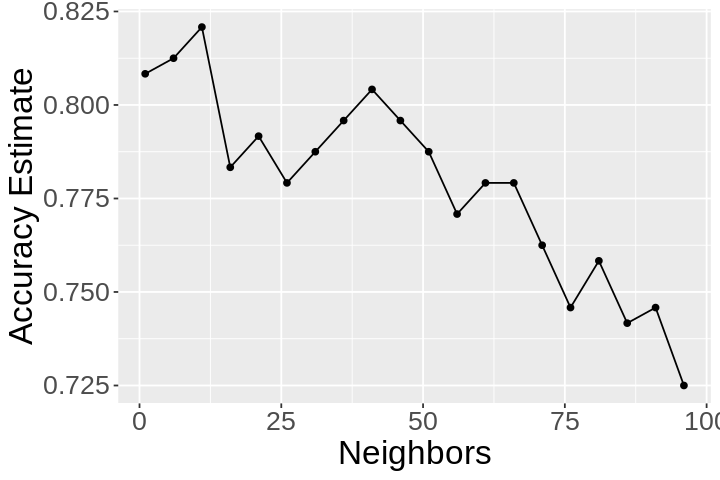

In [34]:
set.seed(2000)

# find the best k neighbour value to use with V-fold cross validation
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = num)

cleveland_recipe <- recipe(num ~ ., data = cleveland_train) |>
    # step_scale(sd_trestbps, sd_chol, sd_thalach) |>
    # step_center(sd_trestbps, sd_chol, sd_thalach) |>
    step_upsample(num, over_ratio = 1, skip = T) |>
    prep()

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

gridvals = tibble(neighbors = seq(from = 1, to = 100, by = 5))

cleveland_results <- workflow() |>
            add_recipe(cleveland_recipe) |>
            add_model(cleveland_spec) |>
            tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            arrange(desc(mean))
cleveland_results

# cleveland_std_err <- cleveland_results |>
#                     group_by(std_err) |>
#                     summarize(max_std_err = max(std_err)) |>
#                     arrange(desc(max_std_err)) |>
#                     head(1)
# cleveland_std_err

# plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- cleveland_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot

In [35]:
set.seed(2000)

# compare the accuracy of predictions to the true values in the test set
cleveland_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(cleveland_best_spec) |>
  fit(data = cleveland_train)

cleveland_predictions <- predict(cleveland_fit, cleveland_test) |> 
    bind_cols(cleveland_test)

cleveland_acc <- cleveland_predictions |> 
    metrics(truth = num, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
cleveland_acc

cleveland_cm <- cleveland_predictions |> 
    conf_mat(truth = num, estimate = .pred_class)
cleveland_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.804878


          Truth
Prediction buff sick
      buff   35   10
      sick    6   31

accuracy = number of correct predictions/total number of predictions *100%

precision = number of correct positive predictions/total number of positive predictions

recall = number of correct positive predictions/total number of test set observations

In [36]:
#calculate accuracy
accuracy <- (35 + 31)/(35 + 31 + 10 + 6)

#note: we wish to predict sick observations; sick is our positive prediction
#calculate precision
precision <- 31/(31 + 6)

#calculate recall
recall <- 31/(31 + 10)

metrics <- c(accuracy, precision, recall)
metrics

[1] 0.8048780 0.8378378 0.7560976

### Work Cited
Marateb HR, Goudarzi S. A noninvasive method for coronary artery diseases diagnosis using a clinically-interpretable fuzzy rule-based system. J Res Med Sci. 2015 Mar;20(3):214-23. PMID: 26109965; PMCID: PMC4468223.